In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#指定默认字体
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft Yahei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
mu = np.arange(0.3, 0.71, 0.1)
learn = np.arange(0.2, 1.01, 0.2)
radius = np.arange(3, 11.1, 2)
sense = np.arange(0.2, 1.01, 0.2)
year = np.arange(2006,2017,1)
print(mu)
print(learn)
print(radius)
print(sense)
print(year)

[0.3 0.4 0.5 0.6 0.7]
[0.2 0.4 0.6 0.8 1. ]
[ 3.  5.  7.  9. 11.]
[0.2 0.4 0.6 0.8 1. ]
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


In [289]:
# load data

In [263]:
simulation = pd.read_csv(open(r'../data/abm_farmer/simulations.csv'))
sim = simulation[['id','mu','learn','sense','radius']]
country = pd.read_csv(r'../data/abm_farmer/country_traces.csv')
farmerInit = pd.read_csv(open(r'../data/abm_farmer/farmer_inits.csv'))
farmerAnchor = pd.read_csv(r'../data/abm_farmer/farmer_anchors.csv')

In [264]:
def getSimId(mu, learn, sense, radius):
    temp = sim[(sim['mu']==mu) & (sim['learn']==learn) & (sim['sense']==sense) & (sim['radius']==radius)]
    return temp['id'].values[0]

# sim = simulation[['id','mu','learn','sense','radius']][(simulation['mu']==0.3) & (simulation['learn']==0.2) & (simulation['sense']==0.2) & (simulation['radius']==3)]
# print(sim['id'].values[0])
# print(sim.loc[0:3,'id']) #基于标签      iloc[0:1, 2:5] 完全是基于索引
# print(getSimId(0.3,0.2,0.2,5))

In [265]:
def getCountryData(simId, sortedBy):
    temp = country[country['sim_id'] == simId].sort_values(by=sortedBy)
    return temp
    
# temp = country[country['sim_id'] == getSimId(0.3,0.2,0.2,3)].sort_values(by='time')
# print(temp)
# print(getCountryData(getSimId(0.3,0.2,0.2,5), 'time'))

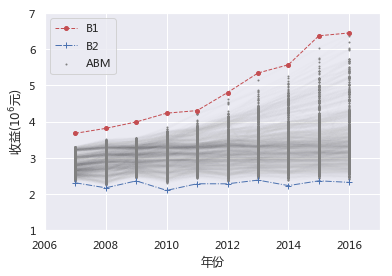

In [266]:
simId = np.arange(1,750.1, 1)
year = np.arange(2007,2017,1)
plotX = []
plotY = []
plotMaxY = []
plotMinY = []

for y in year:
    strY = str(y) + '-09-20 00:00:00'
    tempY = country[country['time']==strY]['crop_income'].values
    tempX = [y] * len(tempY)
    plotX.append(tempX)
    plotY.append(tempY)
    plotMaxY.append(tempY.max())
    plotMinY.append(tempY.min())
    

plt.ylabel(r'收益($10^6$元)')
plt.xlabel(r'年份')

plotY = np.array(plotY) / 1e6
np.random.seed(666)
plotB1Y = np.array(plotMaxY) / 1e6 + np.random.normal(0.0,0.2, size=len(plotMaxY)) + 0.2
np.random.seed(20)
plotB2Y = np.array(plotMinY) / 1e6 + np.random.normal(0.0,0.05, size=len(plotMaxY)) - 0.1

plt.scatter(plotX, plotY, s=1, c='grey', label='ABM')
plt.plot(plotX, plotY, linewidth=2.0, color='grey', alpha=0.01)

plt.plot(year, plotB1Y, 'ro--', linewidth=1, markersize=4, label='B1')

plt.plot(year, plotB2Y, 'b+-.', linewidth=1, markersize=6, label='B2')

# plt.plot([2007,2016.5], [3.4, 3.4], 'g-', linewidth=1, alpha=0.5)

plt.legend()
plt.axis([2006, 2017, 1, 7])

plt.show()

In [286]:
country['time'] = country['time'].apply(lambda x: x.split('-')[0])

simId_df = sim[(sim['learn']==0.6) & (sim['radius']==7) & (sim['sense']==0.6)]
# print(simId_df)
simIds = simId_df['id'].values
countryMu = country[country['sim_id'].isin(simIds)]
countryMu['sim_id'] = countryMu['sim_id'].map(lambda x: simId_df[simId_df['id']==x]['mu'].values[0])
countryMu = countryMu[countryMu['time'] != '2006']

print(countryMu)
print(countryMu.columns)

        id  sim_id  time  precipitation  crop_irrigation  rice_irrigation  \
3966  3967     0.3  2007         455.70        462937.64        395925.46   
3970  3971     0.3  2008         475.98        328978.88        290908.39   
3974  3975     0.3  2009         265.96        469009.19        401609.49   
3978  3979     0.3  2010         599.14        343555.24        305561.42   
3982  3983     0.3  2011         519.94        372370.25        337917.90   
3986  3987     0.3  2012         505.97        420145.66        376755.35   
3990  3991     0.3  2013         470.40        294644.93        282977.71   
3994  3995     0.3  2014         525.80        393464.60        350419.68   
3998  3999     0.3  2015         475.48        350873.19        331880.12   
4002  4003     0.3  2016        1100.37        320576.29        310041.61   
4011  4012     0.4  2007         455.70        439057.23        354083.19   
4015  4016     0.4  2008         475.98        309410.68        258401.86   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


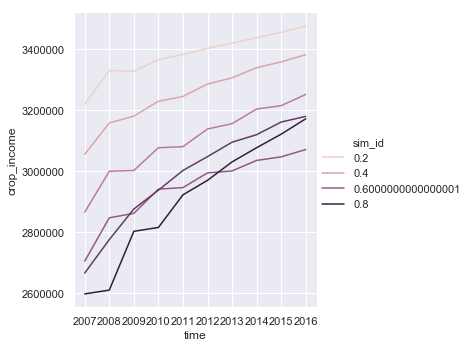

In [287]:
import seaborn as sns
sns.set(style="darkgrid")
sns.relplot(x="time", y="crop_income", hue="sim_id", markers=True, dashes=False, kind="line", data=countryMu);

In [ ]:
simIds = sim[sim['mu'] == 0.3]['id'].values
countryMu = country[country['sim_id'].isin(simIds)]
countryMu = countryMu[countryMu['time'] != '2006']
countryMu['crop_income'] = countryMu['crop_income'] / 1e6
country.columns

In [ ]:
import seaborn as sns
sns.catplot(x="time", y="crop_income", kind="box", data=countryMu)